In [1]:
"""
- Normal
    - Tension_Normal.csv
    - NTRNL_Normal # subfolder
        - 05-31 23_35_19.txt
        ...
    - XTRNL_Normal # subfolder
        - 20230531_233519.csv
        ...
- CoreExposed
    - Tension_CoreExposed.csv
    - NTRNL_CoreExposed # subfolder
        - 06-01 16_04_36.txt
        ...
    - XTRNL_CoreExposed # subfolder
        - 20230601_160436.csv
        ...
- CoreSevered
    - Tension_CoreSevered.csv
    - NTRNL_CoreSevered # subfolder
        - 06-01 01_49_17.txt
        ...
    - XTRNL_CoreSevered # subfolder
        - 20230601_014917.csv
        ...
- SideDamaged
    - Tension_SideDamaged.csv
    - NTRNL_SideDamaged # subfolder
        - 05-31 20_54_14.txt
        ...
    - XTRNL_SideDamaged # subfolder
        - 20230531_205414.csv
        ...
"""

'\n- Normal\n    - Tension_Normal.csv\n    - NTRNL_Normal # subfolder\n        - 05-31 23_35_19.txt\n        ...\n    - XTRNL_Normal # subfolder\n        - 20230531_233519.csv\n        ...\n- CoreExposed\n    - Tension_CoreExposed.csv\n    - NTRNL_CoreExposed # subfolder\n        - 06-01 16_04_36.txt\n        ...\n    - XTRNL_CoreExposed # subfolder\n        - 20230601_160436.csv\n        ...\n- CoreSevered\n    - Tension_CoreSevered.csv\n    - NTRNL_CoreSevered # subfolder\n        - 06-01 01_49_17.txt\n        ...\n    - XTRNL_CoreSevered # subfolder\n        - 20230601_014917.csv\n        ...\n- SideDamaged\n    - Tension_SideDamaged.csv\n    - NTRNL_SideDamaged # subfolder\n        - 05-31 20_54_14.txt\n        ...\n    - XTRNL_SideDamaged # subfolder\n        - 20230531_205414.csv\n        ...\n'

In [249]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.spatial import distance
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

##### 수집한 신호로부터 대푯값 추출 및 표준화
##### 변수 'Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Type', 'ConfucionMatrix' 생성

In [39]:
Directory_Path = 'C:/Users/99kit/Desktop/CapstoneDesign2/'
list_root_directory = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged']

def calculate_statistics(data):
    mean = np.mean(data)
    var = np.var(data)
    skew = scipy.stats.skew(data)
    kurt = scipy.stats.kurtosis(data)
    return mean, var, skew, kurt

data_frames = {}

for directory in list_root_directory:
    os.chdir(os.path.join(Directory_Path, directory))

    Tension = pd.read_csv(f"Tension_{directory}.csv", encoding='cp949')
    Tension['Unnamed: 0'] = pd.to_datetime(Tension['Unnamed: 0'], format='[%Y/%m/%d] %H:%M:%S')
    Tension['Formatted_Time'] = Tension['Unnamed: 0'].dt.strftime(f'NTRNL_{directory}\\%m-%d %H_%M_%S.txt')

    list_max_values = []
    for csv_file in glob.glob('*/*.csv'):
        df = pd.read_csv(csv_file)
        list_max_values.append(df['External Sound'].max())
    Tension['Max_EXT_Sound'] = list_max_values

    statistics = {}
    for txt_file in glob.glob('*/*.txt'):
        with open(txt_file, 'r') as file:
            data = [int(line.strip().split(',')[0]) for line in file if len(line.strip().split(',')) == 3]
            statistics[txt_file] = calculate_statistics(data)

    for stat_name in ['Mean', 'Variance', 'Skewness', 'Kurtosis']:
        Tension[stat_name] = Tension['Formatted_Time'].map(lambda x: statistics.get(x, (np.nan, np.nan, np.nan, np.nan))[['Mean', 'Variance', 'Skewness', 'Kurtosis'].index(stat_name)])
        Tension[stat_name].interpolate(inplace=True)

    Q1 = Tension['Max_EXT_Sound'].quantile(0.25)
    Q3 = Tension['Max_EXT_Sound'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_max_ext_sound = Tension[(Tension['Max_EXT_Sound'] < lower_bound) | (Tension['Max_EXT_Sound'] > upper_bound)]

    Q1_mean = Tension['Mean'].quantile(0.25)
    Q3_mean = Tension['Mean'].quantile(0.75)
    IQR_mean = Q3_mean - Q1_mean
    lower_bound_mean = Q1_mean - 1.5 * IQR_mean
    upper_bound_mean = Q3_mean + 1.5 * IQR_mean
    outliers_mean_ntrnl_sound = Tension[(Tension['Mean'] < lower_bound_mean) | (Tension['Mean'] > upper_bound_mean)]

    common_indices = outliers_max_ext_sound.index.intersection(outliers_mean_ntrnl_sound.index)
    Tension.loc[common_indices, 'Mean'] = np.nan
    Tension['Mean'].interpolate(inplace=True)

    Tension = Tension.drop(['Formatted_Time', 'Max_EXT_Sound'], axis=1)
    Tension['Type'] = directory

    Tension.loc[Tension['Type'] != 'Normal', 'Confusion Matrix'] = 'Anomaly'
    Tension.loc[Tension['Type'] == 'Normal', 'Confusion Matrix'] = 'Normal'

    data_frames[directory] = Tension

tb_data = pd.concat(data_frames.values(), ignore_index=True)
tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

list_independent_variables = ['Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis']

data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
tb_data_standardized = pd.DataFrame(data_standardized, columns=list_independent_variables)
tb_data[list_independent_variables] = tb_data_standardized

tb_data

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal
...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Anomaly
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Anomaly
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Anomaly
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Anomaly


##### 4가지 Type의 분포 확인
##### Mutual Information(상호 정보량)을 이용한 변수 중요도 파악
##### 주성분 분석을 이용한 차원 축소

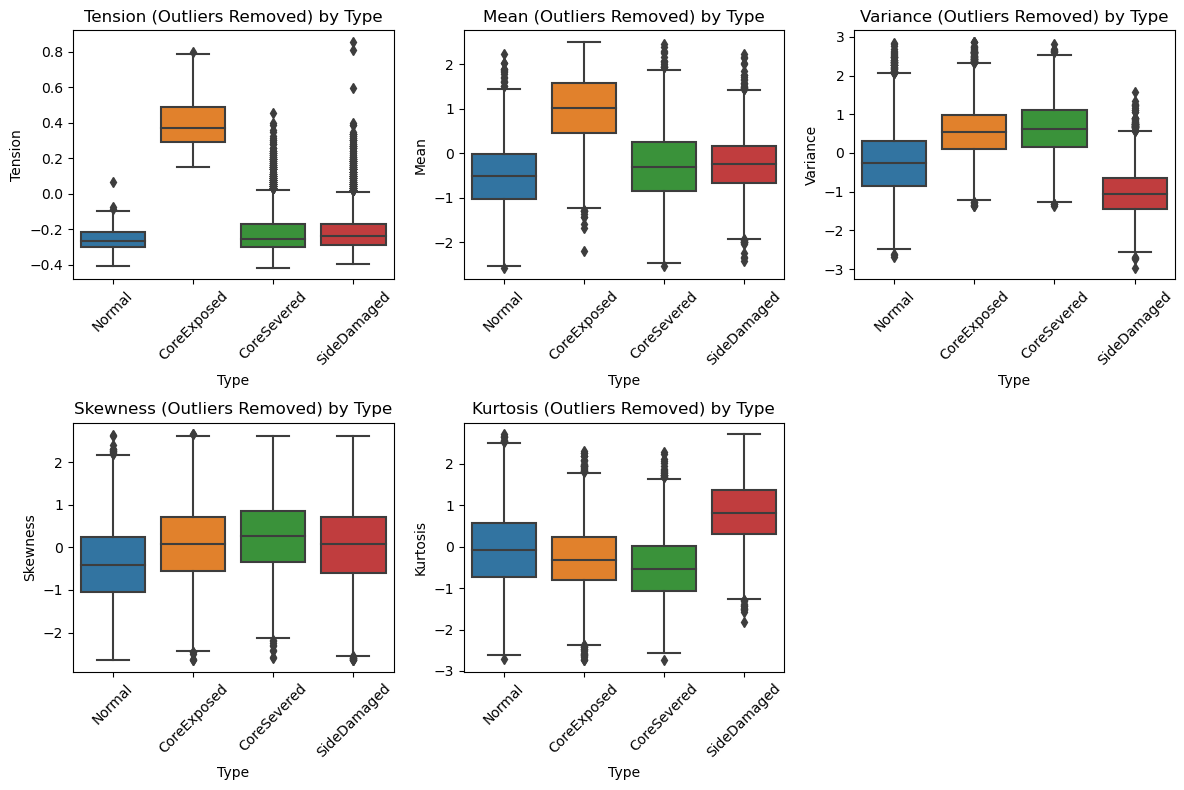

In [41]:
# 박스 플롯 그리기
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.boxplot(x='Type', y=col, data=data_no_outliers)
    plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=45)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

변수 중요도
Tension     0.571682
Variance    0.326099
Mean        0.237760
Kurtosis    0.169220
Skewness    0.023525
dtype: float64


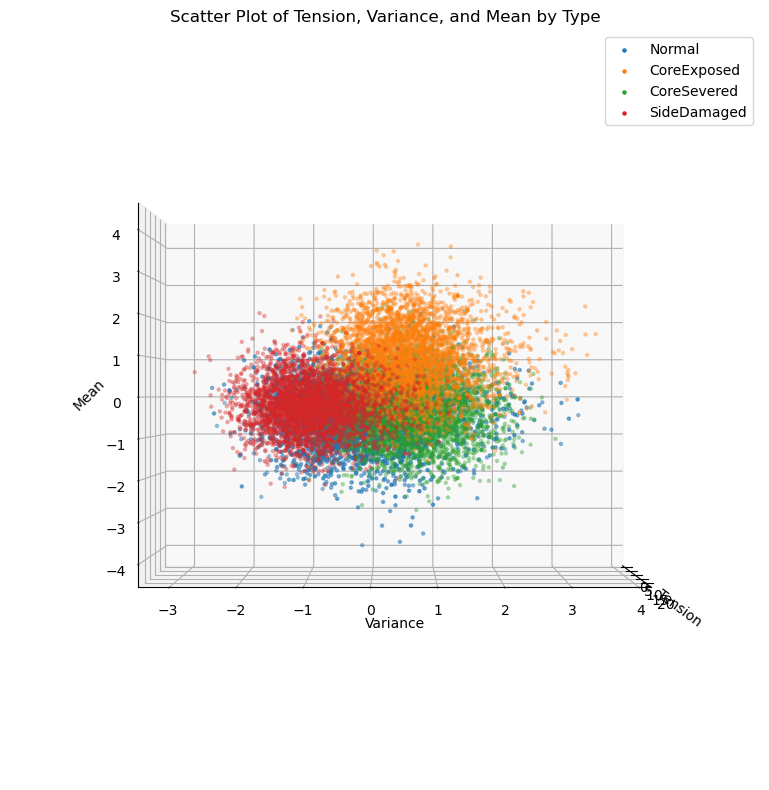

In [42]:
# 독립 변수와 타겟 변수를 선택
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Type']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

tension = tb_data['Tension']
variance = tb_data['Variance']
mean = tb_data['Mean']
type = tb_data['Type']

for t in tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(tension[mask], variance[mask], mean[mask], label = t, marker = '.')

ax.set_xlabel('Tension', rotation=45)
ax.set_ylabel('Variance', rotation=45)
ax.set_zlabel('Mean', rotation=45)

azimuth_angle = 0
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Variance, and Mean by Type')
plt.tight_layout()
plt.show()

주성분의 누적 설명력: [0.38105984 0.62837282 0.83513909 0.97441389 1.        ]


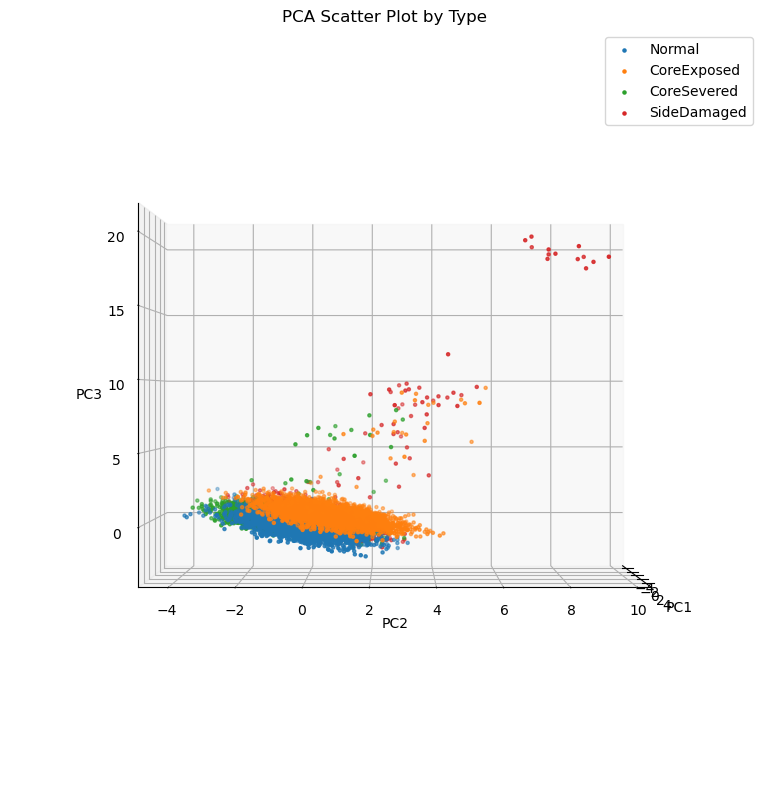

In [43]:
pca = PCA()
pca_tb_data = pca.fit_transform(tb_data[list_independent_variables])
list_pca_tb_data_cols = [f'PC{i+1}' for i in range(pca_tb_data.shape[1])]
pca_tb_data = pd.concat([pd.DataFrame(data = pca_tb_data, columns = list_pca_tb_data_cols), tb_data[['Type', 'Confusion Matrix']]], axis = 1)

explained_var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
print(f'주성분의 누적 설명력: {explained_var_ratio_cumsum}')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_tb_data['PC1']
pc2 = pca_tb_data['PC2']
pc3 = pca_tb_data['PC3']
type = pca_tb_data['Type']

for t in pca_tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 0
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot by Type')
plt.tight_layout()
plt.show()

##### Normal과 Anomaly 데이터의 분포 비교
##### 상호 정보량을 이용한 변수 중요도 파악
##### 주성분 분석을 이용한 차원 축소

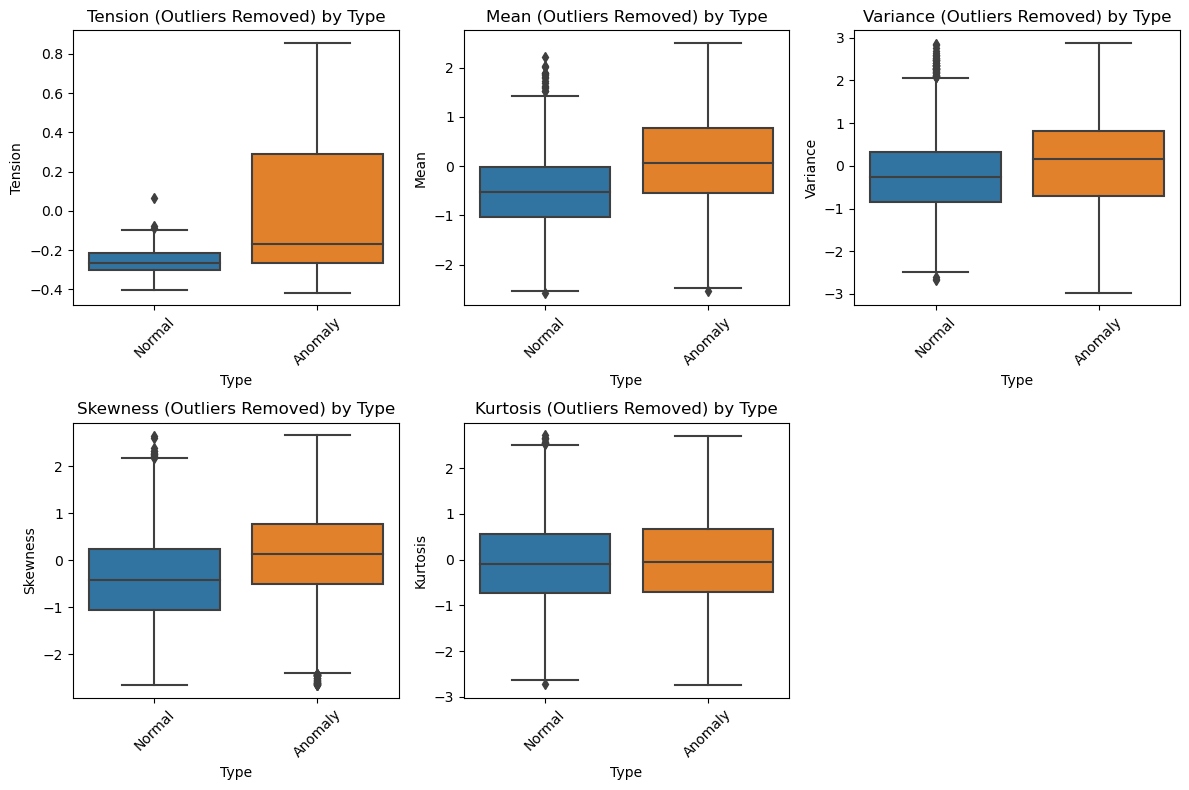

In [44]:
# 박스 플롯 그리기
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.boxplot(x='Confusion Matrix', y=col, data=data_no_outliers)
    plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=45)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

변수 중요도
Tension     0.120450
Mean        0.050333
Skewness    0.028058
Variance    0.021103
Kurtosis    0.001922
dtype: float64


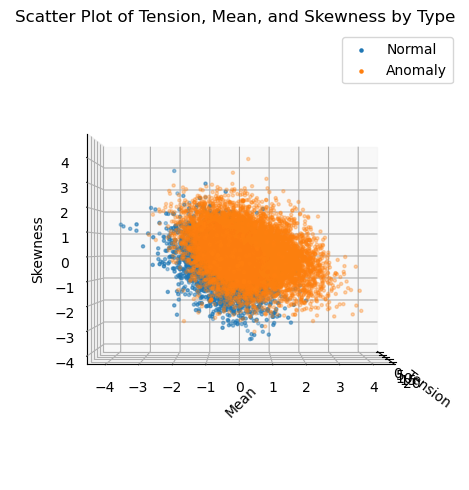

In [57]:
# 독립 변수와 타겟 변수를 선택
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111, projection='3d')
tension = tb_data['Tension']
mean = tb_data['Mean']
skewness = tb_data['Skewness']
confusion_matrix = tb_data['Confusion Matrix']

for t in tb_data['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(tension[mask], mean[mask], skewness[mask], label = t, marker = '.')

ax.set_xlabel('Tension', rotation=45)
ax.set_ylabel('Mean', rotation=45)
ax.set_zlabel('Skewness', rotation=45)

azimuth_angle = -0
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Mean, and Skewness by Type')
plt.tight_layout()
plt.show()

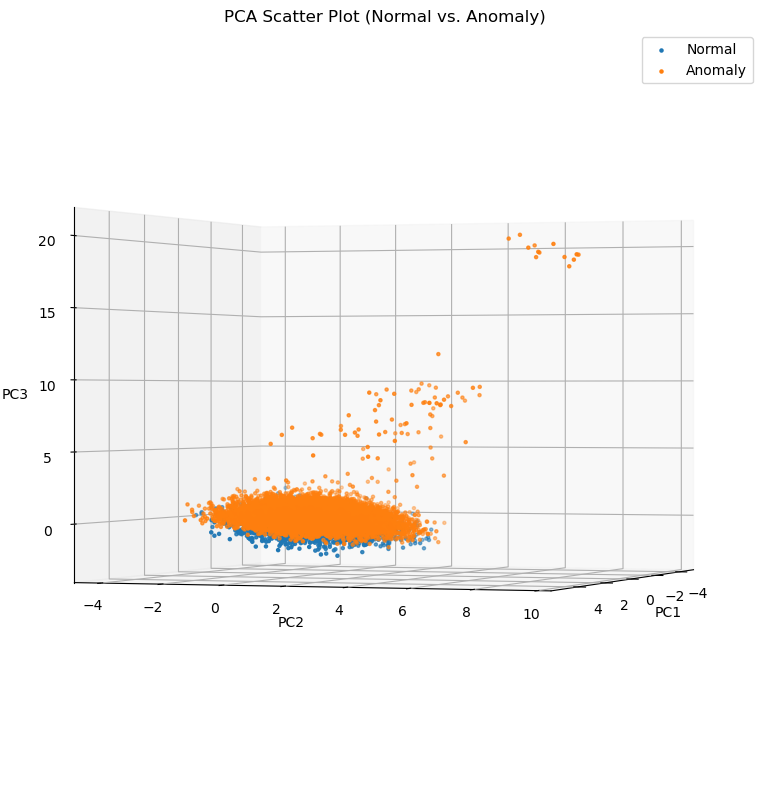

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_tb_data['PC1']
pc2 = pca_tb_data['PC2']
pc3 = pca_tb_data['PC3']
type = pca_tb_data['Confusion Matrix']

for t in pca_tb_data['Confusion Matrix'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 20
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot (Normal vs. Anomaly)')
plt.tight_layout()
plt.show()

##### Normal에 대해 집단과 데이터 포인트 사이의 Mahalanobis 거리 계산
##### 신뢰수준(n%)을 정하고 여러 개의 n분위수를 Bootstrap을 이용하여 구한 뒤 그 평균을 관리한계로 설정
##### False Alarm 발생

In [58]:
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시

type_normal = tb_data[tb_data['Type'] == 'Normal']
type_not_normal = tb_data[tb_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(row):
    x = row[list_independent_variables]
    return distance.mahalanobis(x, normal_mean, normal_cov)

type_normal['Mahalanobis Distance'] = type_normal.apply(mahalanobis_distance, axis = 1)

bootstrap_iterations = 500
confidence_level = 95

list_bootstrap_statistics = []

for _ in range(bootstrap_iterations):
    bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size = len(type_normal), replace = True)
    list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

control_limit = np.mean(list_bootstrap_statistics)
print(f'confidence level: {confidence_level}%')
print(f'control limit: {control_limit}')

type_not_normal['Mahalanobis Distance'] = type_not_normal.apply(mahalanobis_distance, axis = 1)

type_normal.loc[type_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'FalseAlarm' # 'Normal' = TrueNegative
type_not_normal.loc[type_not_normal['Mahalanobis Distance'] <= control_limit, 'Confusion Matrix'] = 'Type2Error' # 'Anomaly' = TruePositive

tb_data = pd.concat([type_normal, type_not_normal], axis = 0)

tb_data

confidence level: 95%
control limit: 3.5757911077143825


,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal,1.109174
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal,1.373444
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal,1.126269
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal,1.522023
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal,2.703300
...,...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Type2Error,2.539571
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Type2Error,1.295017
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Type2Error,0.712283
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Type2Error,2.965364


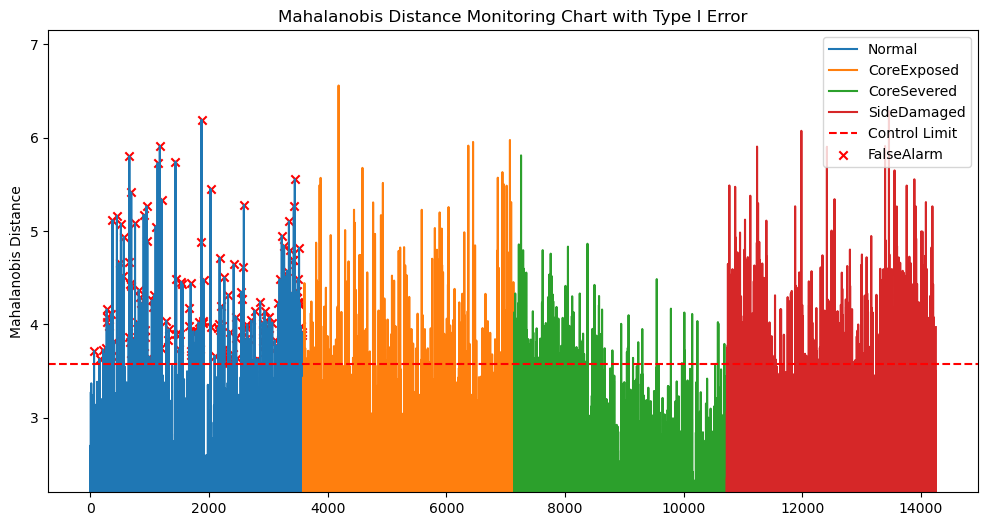

In [59]:
mahalanobis_distance = tb_data['Mahalanobis Distance']

false_alarm_indices = tb_data[tb_data['Confusion Matrix'] == 'FalseAlarm'].index

plt.figure(figsize=(12, 6))

for t in tb_data['Type'].unique():
    type_indices = tb_data[tb_data['Type'] == t].index
    plt.plot(type_indices, mahalanobis_distance[type_indices], label=f'{t}') # 각 'Type'에 대한 Mahalanobis 거리 플롯
    
plt.axhline(y=control_limit, color='red', linestyle='--', label='Control Limit') # Control Limit 그래프 그리기

plt.scatter(false_alarm_indices, mahalanobis_distance[false_alarm_indices], c='red', marker='x', label='FalseAlarm') # 'Confusion Matrix' 값이 'Type1Error'인 데이터 포인트 표시

plt.ylabel('Mahalanobis Distance')
plt.title('Mahalanobis Distance Monitoring Chart with Type Ⅰ Error')
plt.legend()

plt.ylim(2.2, control_limit * 2) # y축 범위 설정

plt.show()

변수 중요도
Variance    0.136598
Kurtosis    0.122509
Tension     0.120631
Mean        0.058121
Skewness    0.048061
dtype: float64


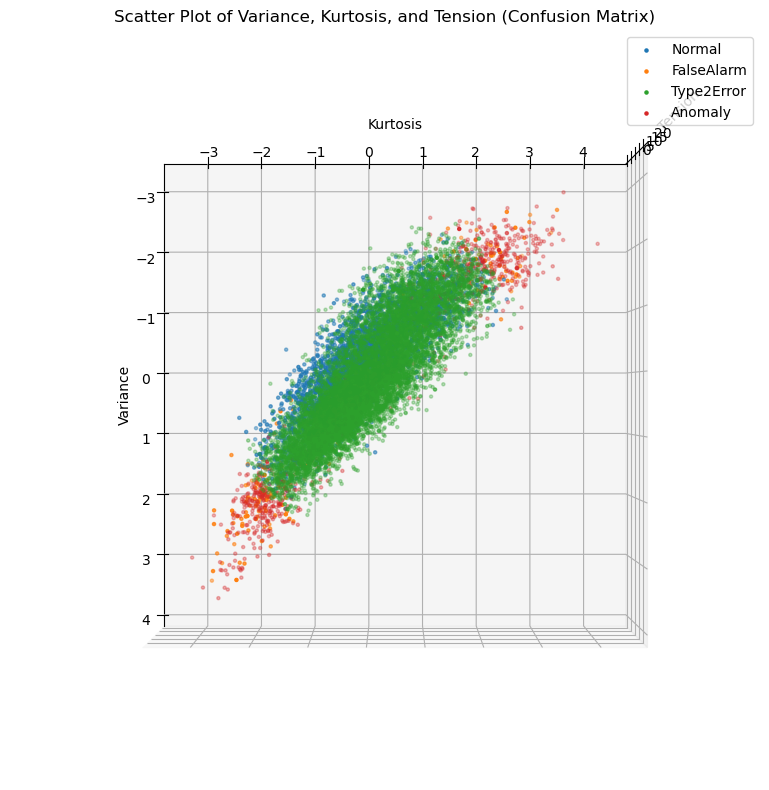

In [63]:
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, projection='3d')
variance = tb_data['Variance']
kurtosis = tb_data['Kurtosis']
tension = tb_data['Tension']
confusion_matrix = tb_data['Confusion Matrix']

for t in tb_data['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(variance[mask], kurtosis[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Variance', rotation=45)
ax.set_ylabel('Kurtosis', rotation=45)
ax.set_zlabel('Tension', rotation=45)

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Variance, Kurtosis, and Tension (Confusion Matrix)')
plt.tight_layout()
plt.show()

##### 관리한계를 넘은 관측치는 False Alarm과 Anomaly로 이루어짐
##### False Alarm Classification (FAC) 적용을 위해 False Alarm Data의 10%를 불량으로 취급하는 Threshold 설정은 아직 안 함

In [250]:
AEandAnomaly = tb_data[(tb_data['Confusion Matrix'] == 'FalseAlarm') | (tb_data['Confusion Matrix'] == 'Anomaly')]
AEandAnomaly = AEandAnomaly.reset_index(drop = True) # False는 기존 인덱스를 새로운 열로 추가
AEandAnomaly

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:36:20,-0.287165,-1.142436,2.025296,0.751861,-1.828788,Normal,FalseAlarm,3.714023
1,2023-05-31 23:37:52,-0.263594,0.428137,1.351306,-0.153471,-2.541283,Normal,FalseAlarm,3.630753
2,2023-05-31 23:38:54,-0.275380,-2.953189,-0.250886,2.169625,0.092460,Normal,FalseAlarm,3.729624
3,2023-05-31 23:39:21,-0.228238,-0.602993,2.056393,-0.708901,-1.878521,Normal,FalseAlarm,3.683356
4,2023-05-31 23:39:40,-0.334307,-3.965058,-0.181081,1.416356,0.340821,Normal,FalseAlarm,3.749816
...,...,...,...,...,...,...,...,...,...
865,2023-05-31 21:53:12,-0.240023,0.059582,-1.773858,2.506716,1.821267,SideDamaged,Anomaly,4.430479
866,2023-05-31 21:53:25,-0.275380,-0.602244,-2.040108,2.193316,1.245957,SideDamaged,Anomaly,4.074471
867,2023-05-31 21:53:32,-0.086811,-0.000313,-1.789346,1.122283,1.889343,SideDamaged,Anomaly,3.660788
868,2023-05-31 21:53:34,-0.369664,1.205989,-2.081507,1.232669,1.756646,SideDamaged,Anomaly,3.943354


변수 중요도
Tension     0.095223
Mean        0.045030
Skewness    0.043385
Variance    0.003748
Kurtosis    0.000000
dtype: float64


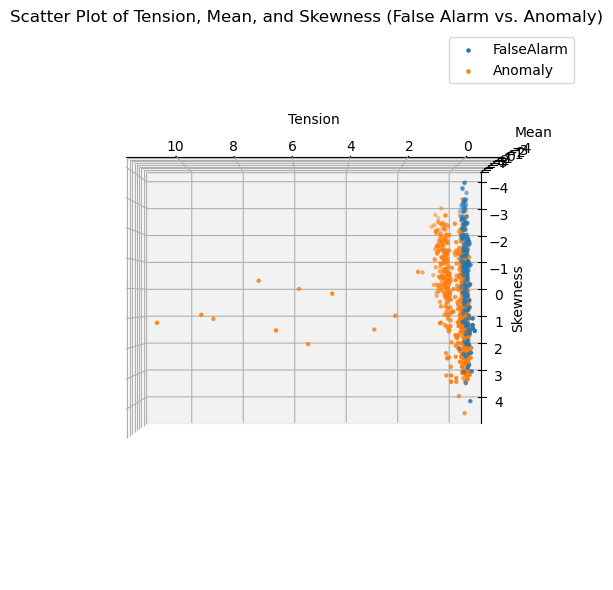

In [251]:
X = AEandAnomaly[list_independent_variables]  # 독립 변수
y = AEandAnomaly['Confusion Matrix']  # 타겟 변수

# 상호의존정보
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')
tension = AEandAnomaly['Tension']
mean = AEandAnomaly['Mean']
skewness = AEandAnomaly['Skewness']
confusion_matrix = AEandAnomaly['Confusion Matrix']

for t in AEandAnomaly['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(tension[mask], mean[mask], skewness[mask], label = t, marker = '.')

ax.set_xlabel('Tension')
ax.set_ylabel('Mean')
ax.set_zlabel('Skewness')

azimuth_angle = 90
elevation_angle = 180
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Mean, and Skewness (False Alarm vs. Anomaly)')
plt.tight_layout()
plt.show()

##### 하하하하하하하하하하하하하하하하하하하하하
##### IQR을 이용하여 False Alarm의 Extreme Outliers를 정의할 수 있는 Outer Fence를 만듭시다.(Q3 + IQR * 3)

Upper Outer Fence: 0.019258668380449484


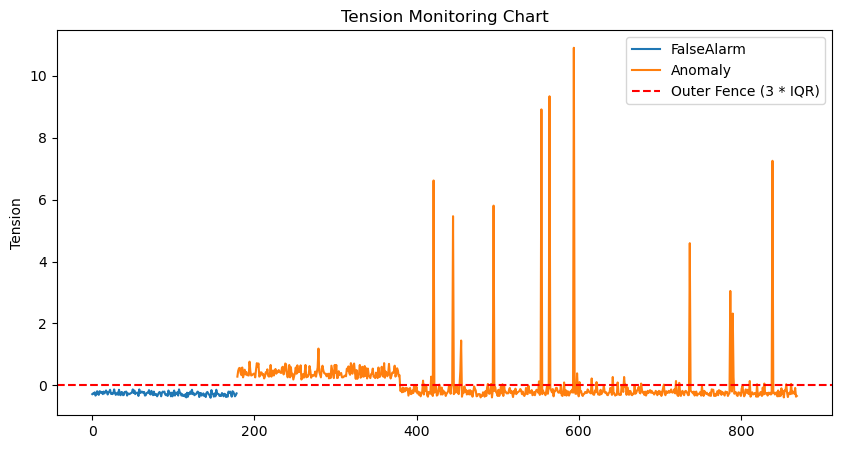

,index,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,0,2023-05-31 23:36:20,-0.287165,-1.142436,2.025296,0.751861,-1.828788,Normal,FalseAlarm,3.714023
1,1,2023-05-31 23:37:52,-0.263594,0.428137,1.351306,-0.153471,-2.541283,Normal,FalseAlarm,3.630753
2,2,2023-05-31 23:38:54,-0.275380,-2.953189,-0.250886,2.169625,0.092460,Normal,FalseAlarm,3.729624
3,3,2023-05-31 23:39:21,-0.228238,-0.602993,2.056393,-0.708901,-1.878521,Normal,FalseAlarm,3.683356
4,4,2023-05-31 23:39:40,-0.334307,-3.965058,-0.181081,1.416356,0.340821,Normal,FalseAlarm,3.749816
...,...,...,...,...,...,...,...,...,...,...
625,865,2023-05-31 21:53:12,-0.240023,0.059582,-1.773858,2.506716,1.821267,SideDamaged,Anomaly,4.430479
626,866,2023-05-31 21:53:25,-0.275380,-0.602244,-2.040108,2.193316,1.245957,SideDamaged,Anomaly,4.074471
627,867,2023-05-31 21:53:32,-0.086811,-0.000313,-1.789346,1.122283,1.889343,SideDamaged,Anomaly,3.660788
628,868,2023-05-31 21:53:34,-0.369664,1.205989,-2.081507,1.232669,1.756646,SideDamaged,Anomaly,3.943354


In [252]:

AE = tb_data[(tb_data['Confusion Matrix'] == 'FalseAlarm')]
AE = AE.reset_index(drop = True) # False는 기존 인덱스를 새로운 열로 추가

Q1 = AE['Tension'].quantile(0.25)
Q3 = AE['Tension'].quantile(0.75)
IQR = Q3 - Q1
outer_fence = Q3 + 3 * IQR
print(f'Upper Outer Fence: {outer_fence}')

tension = AEandAnomaly['Tension']

plt.figure(figsize=(10, 5))

for t in AEandAnomaly['Confusion Matrix'].unique():
    type_indices = AEandAnomaly[AEandAnomaly['Confusion Matrix'] == t].index
    plt.plot(type_indices, tension[type_indices], label=f'{t}') # 각 'Type'에 대한 Mahalanobis 거리 플롯
    
plt.axhline(y=outer_fence, color='red', linestyle='--', label='Outer Fence (3 * IQR)') # Control Limit 그래프 그리기

plt.ylabel('Tension')
plt.title('Tension Monitoring Chart')
plt.legend()
plt.show()

fac_target = AEandAnomaly[(AEandAnomaly['Tension'] < outer_fence)]
extreme_outliers = AEandAnomaly[(AEandAnomaly['Tension'] >= outer_fence)]
fac_target = fac_target.reset_index(drop = False)
fac_target # Control Limit은 넘었지만 Outer Fence는 안 넘음
# extreme_outliers # FAC 필요 없이 아묻따 Anomaly. 바로 Type 분류하면 됨

변수 중요도
Skewness    0.103152
Variance    0.051319
Tension     0.035357
Mean        0.028016
Kurtosis    0.026750
dtype: float64


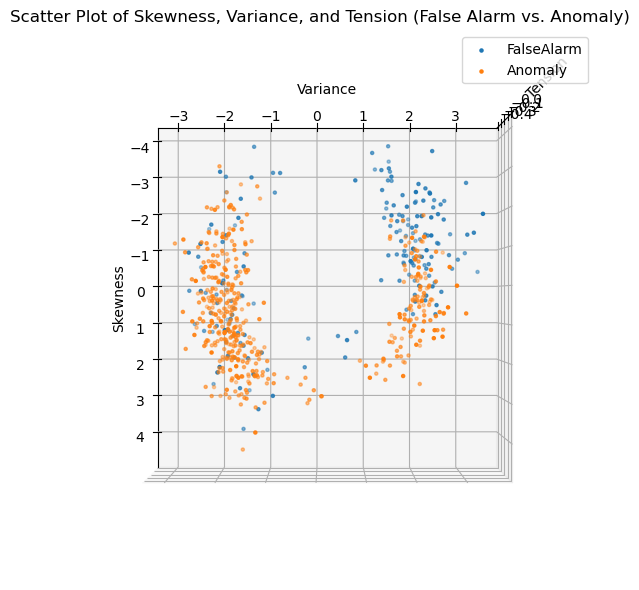

In [253]:
# 독립 변수와 타겟 변수를 선택
X = fac_target[list_independent_variables]  # 독립 변수
y = fac_target['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

skewness = fac_target['Skewness']
variance = fac_target['Variance']
tension = fac_target['Tension']
confusion_matrix = fac_target['Confusion Matrix']

for t in fac_target['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(skewness[mask], variance[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Skewness', rotation=45)
ax.set_ylabel('Variance', rotation=45)
ax.set_zlabel('Tension', rotation=45)

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Skewness, Variance, and Tension (False Alarm vs. Anomaly)')
plt.tight_layout()
plt.show()

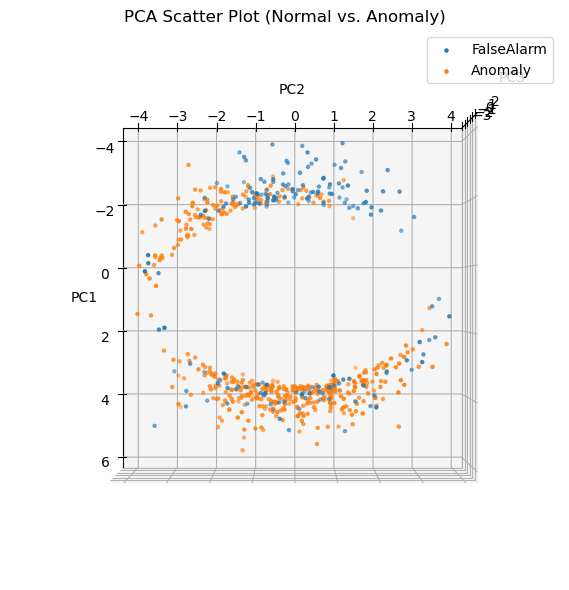

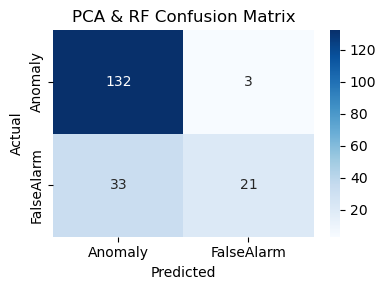

PCA & Random Forest Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.80      0.98      0.88       135
  FalseAlarm       0.88      0.39      0.54        54

    accuracy                           0.81       189
   macro avg       0.84      0.68      0.71       189
weighted avg       0.82      0.81      0.78       189



In [256]:
from sklearn.metrics import confusion_matrix, classification_report # 왜 가끔 말을 안 듣지

list_dependent_variables = ['Type', 'Confusion Matrix']

# PCA
pca = PCA(n_components = 3)
pca_fa = pca.fit_transform(fac_target.loc[fac_target['Confusion Matrix'] == 'FalseAlarm', list_independent_variables])
list_pca_fa_cols = [f'PC{i+1}' for i in range(pca_fa.shape[1])]
pca_fa = pd.concat([pd.DataFrame(data = pca_fa, columns = list_pca_fa_cols), fac_target.loc[fac_target['Confusion Matrix'] == 'FalseAlarm', list_dependent_variables]], axis = 1)

pca_ta = pca.transform(fac_target.loc[fac_target['Confusion Matrix'] != 'FalseAlarm', list_independent_variables])
list_pca_ta_cols = [f'PC{i+1}' for i in range(pca_ta.shape[1])]
pca_ta = pd.concat([pd.DataFrame(data = pca_ta, columns = list_pca_ta_cols), fac_target.loc[fac_target['Confusion Matrix'] != 'FalseAlarm', list_dependent_variables].reset_index(drop = True)], axis = 1)

pca_fata = pd.concat([pca_fa, pca_ta], axis = 0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_fata['PC1']
pc2 = pca_fata['PC2']
pc3 = pca_fata['PC3']
type = pca_fata['Confusion Matrix']

for t in pca_fata['Confusion Matrix'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot (Normal vs. Anomaly)')
plt.tight_layout()
plt.show()

X = pca_fata[list_pca_ta_cols]
y = pca_fata['Confusion Matrix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42, max_depth=7)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

class_labels = ['Anomaly', 'FalseAlarm']

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4, 3))

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('PCA & RF Confusion Matrix')

plt.tight_layout()
plt.show()

print("PCA & Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

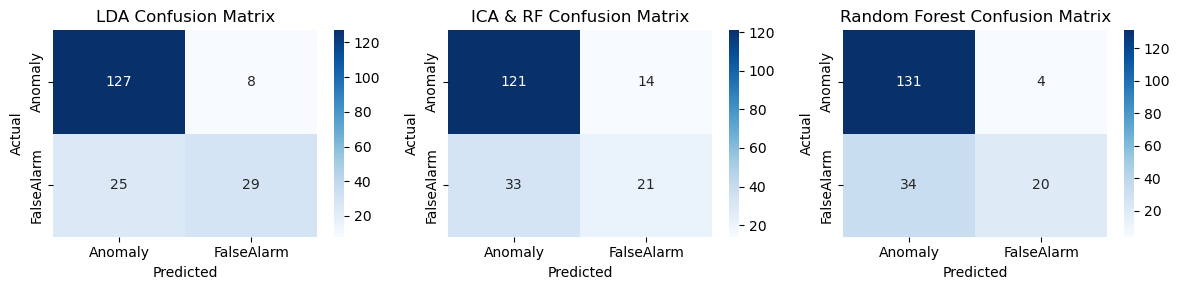

LDA Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.84      0.94      0.89       135
  FalseAlarm       0.78      0.54      0.64        54

    accuracy                           0.83       189
   macro avg       0.81      0.74      0.76       189
weighted avg       0.82      0.83      0.81       189

ICA & Random Forest Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.79      0.90      0.84       135
  FalseAlarm       0.60      0.39      0.47        54

    accuracy                           0.75       189
   macro avg       0.69      0.64      0.65       189
weighted avg       0.73      0.75      0.73       189

Random Forest Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.79      0.97      0.87       135
  FalseAlarm       0.83      0.37      0.51        54

    accuracy                           0.80       189
   macro avg       0.

In [257]:
X = fac_target[list_independent_variables]
y = fac_target['Confusion Matrix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

# ICA
ica = FastICA(n_components=2, random_state=42)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)
classifier_ica = RandomForestClassifier(random_state=42)
classifier_ica.fit(X_train_ica, y_train)
y_pred_ica = classifier_ica.predict(X_test_ica)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42, max_depth=7)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

class_labels = ['Anomaly', 'FalseAlarm']

cm_lda = confusion_matrix(y_test, y_pred_lda)
cm_ica = confusion_matrix(y_test, y_pred_ica)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 3))

plt.subplot(131)
sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LDA Confusion Matrix')

plt.subplot(132)
sns.heatmap(cm_ica, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ICA & RF Confusion Matrix')

plt.subplot(133)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda, target_names=class_labels))

print("ICA & Random Forest Classification Report:")
print(classification_report(y_test, y_pred_ica, target_names=class_labels))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))

##### Anomaly로 판단하는 것을 Positive라고 할 때, FN 적고 Recall이 높은 게 좋은 것 같다.
##### 근데 LDA를 선택해야 할 것 같아요...

In [289]:
# False Alarm으로 예측한 데이터의 인덱스 찾기
fa_indices = [i for i, (pred, true) in enumerate(zip(y_pred_lda, y_test)) if pred == 'FalseAlarm']

# False Alarm으로 예측한 데이터를 제외한 데이터프레임 생성
no_fa = fac_target.drop(fa_indices)
no_fa = pd.concat([no_fa, extreme_outliers], axis = 0).reset_index(drop = True).drop(['index'], axis = 1)

no_fa

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:36:20,-0.287165,-1.142436,2.025296,0.751861,-1.828788,Normal,FalseAlarm,3.714023
1,2023-05-31 23:37:52,-0.263594,0.428137,1.351306,-0.153471,-2.541283,Normal,FalseAlarm,3.630753
2,2023-05-31 23:39:21,-0.228238,-0.602993,2.056393,-0.708901,-1.878521,Normal,FalseAlarm,3.683356
3,2023-05-31 23:39:40,-0.334307,-3.965058,-0.181081,1.416356,0.340821,Normal,FalseAlarm,3.749816
4,2023-05-31 23:39:53,-0.287165,-3.651681,0.833454,1.229173,-1.702369,Normal,FalseAlarm,4.160061
...,...,...,...,...,...,...,...,...,...
828,2023-05-31 21:48:13,0.031044,-0.923888,-1.711577,1.608463,1.987349,SideDamaged,Anomaly,4.027096
829,2023-05-31 21:49:03,0.054615,-1.557904,-1.260066,2.065847,1.297478,SideDamaged,Anomaly,3.741799
830,2023-05-31 21:50:21,7.255579,-0.801135,-1.674527,-0.278597,2.689196,SideDamaged,Anomaly,3.794555
831,2023-05-31 21:52:40,0.031044,-0.031005,-2.423799,-0.887585,2.584101,SideDamaged,Anomaly,4.370030


변수 중요도
Variance    0.569352
Tension     0.546490
Kurtosis    0.503952
Mean        0.312840
Skewness    0.112698
dtype: float64


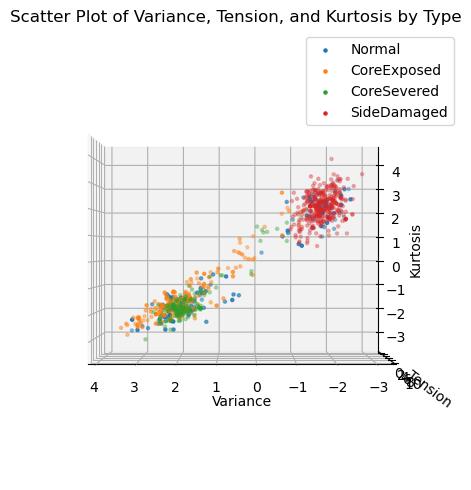

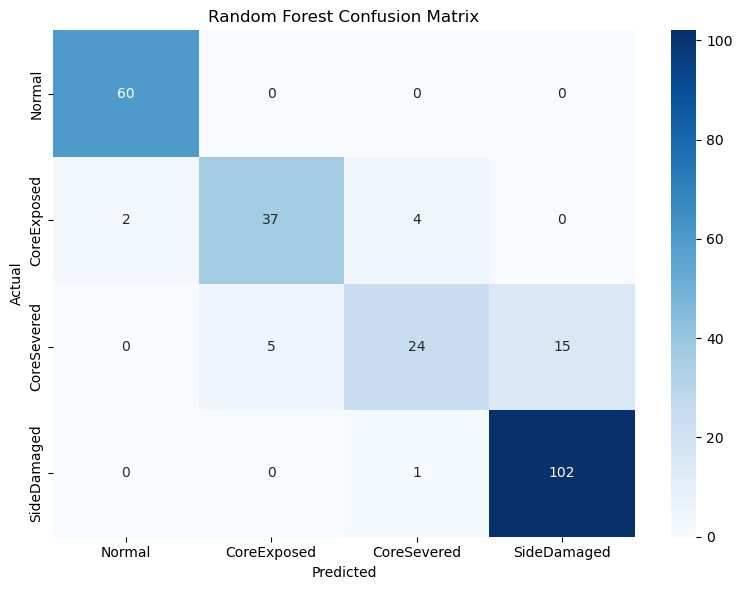

Random Forest Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        60
 CoreExposed       0.88      0.86      0.87        43
 CoreSevered       0.83      0.55      0.66        44
 SideDamaged       0.87      0.99      0.93       103

    accuracy                           0.89       250
   macro avg       0.89      0.85      0.86       250
weighted avg       0.89      0.89      0.88       250



In [332]:
x = no_fa[list_independent_variables]
y = no_fa['Type']

list_type = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged']

mutual_info = mutual_info_classif(x, y, discrete_features='auto', random_state=42)

importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

variance = no_fa['Variance']
tension = no_fa['Tension']
kurtosis = no_fa['Kurtosis']
type = no_fa['Type']

for t in list_type:
    mask = type == t
    ax.scatter(variance[mask], tension[mask], kurtosis[mask], label = t, marker = '.')

ax.set_xlabel('Variance', rotation=45)
ax.set_ylabel('Tension', rotation=45)
ax.set_zlabel('Kurtosis', rotation=45)

azimuth_angle = 90
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Variance, Tension, and Kurtosis by Type')
plt.tight_layout()
plt.show()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

rf = RandomForestClassifier(random_state=42, max_depth=5)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list_type, yticklabels=list_type)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=list_type))

##### 위에서 Normal 포함하는 게 맞나
##### 분류는 왜 잘 되지

##### 그래서, 굳이 FAC 적용해서 얻은 효과는 어떠한가?
##### 제1종오류와 제2종오류 비율 비교 필요